# Niwot Species Distribution Models
### Aaron Westmoreland, Michael Catchen, Will Reed(?)
---


## I. Introduction

- What did we do (multilevel species dist models)

We fit two types of species distribution model to NEON vegetative survey data, focusing on the species _Geum rossii_. We used a Bayesian multilevel framework as well as maximum entropy as implemented in the package maxnet. 

- What data do we have (a lot)

We have presence/absence records from the NEON surveys at 33 sites across 3 years. We also have indices of vegetation, canopy moisture, and canopy nitrogen from lidar flyover data, along with slope, aspect, and elevation.

- What questions did we answer (none to very few)

Our main question was really, can these large scale lidar datasets be used to predict _Geum_ presence across space or forward in time (spoiler: not really).

- How did we do/not do it (stan)
- What big words can we look forward to hearing in the next 20 minutes? (Bayesian multilevel models, Hamiltonian Monte Carlo)
- Can we say anything about the world based on this analysis? (kinda)

Most of the variance in _Geum_ presence was spatial rather than attributable to any of the candidate indices we had.

- Can we predict anything about the world based on this analysis? (fat chance, buster)

### Dependencies

#### Load Libraries

In [1]:
# run devtools::install_github("rmcelreath/rethinking") from rstudio
reqs = c("tidyverse", "Rcpp", "rstan", "mvtnorm", "extraDistr","rethinking", "coda","mvtnorm","devtools","loo","dagitty","GGally","rethinking",
        "purrr","stringr","dplyr","ggplot2",
          "raster", "maxnet", "dismo", "rJava")
lapply(reqs, require, character.only=T)


Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: Rcpp

Loading required package: rstan

Loading required package: StanHeaders

rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Attaching package: ‘rstan’


The following object is masked from ‘package:tidyr’:

    extract


Loading required package: mvtnorm

Loading required package: extraDistr


Attaching package: ‘extraDi

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

[[19]]
[1] TRUE

[[20]]
[1] TRUE

[[21]]
[1] TRUE

## II. The Data

### 2.1 Load Data

The vegetative data was collected in annual surveys at persistent plots maintained by NEON. The plots are each 400 sq m, with subplots of varying scales nested in each. 

<img src ="plot_diagram.png">

We only consider the data from the 1 and 10 sq m subplots. We made this decision for two reasons: 1) it is more feasible to consider an absence a true absence rather than a failure to detect and 2) averages of abiotic covariates are more likely to be representative at the 1 and 10 m scale, whereas at the 100 m or fully aggregated 400 m scale abiotic signal may become distorted or misleading.

In [2]:
presence_absence_data = read.csv('Geum.PA.all.ind.10.m.avg.elev.csv')
# standardize environmental vars
presence_absence_data[,10:ncol(presence_absence_data)] = standardize(presence_absence_data[,10:ncol(presence_absence_data)] )
presence_absence_data$time = presence_absence_data$year - 2018
presence_absence_data$subplot = presence_absence_data$mid_sub
precis(presence_absence_data)
n_plots =  length(unique(presence_absence_data$plot))

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
X,3.635000e+02,209.7224356,4.087500e+01,6.861250e+02,▇▇▇▇▇▇▇▂
Easting,4.515599e+05,1194.3055213,4.493850e+05,4.536260e+05,▂▁▇▁▇▃▇▂▃▂
Northing,4.433183e+06,812.2656754,4.431776e+06,4.434395e+06,▂▇▅▅▇▇▁
PA,3.870523e-01,0.4874116,0.000000e+00,1.000000e+00,▇▁▁▁▁▁▁▁▁▅
plot,NaN,NA,NA,NA,
top_sub,3.600000e+01,4.4853785,3.100000e+01,4.100000e+01,▇▁▁▁▁▁▁▁▃▃
mid_sub,3.625000e+01,4.4781423,3.110000e+01,4.140000e+01,▇▇▁▁▁▁▁▁▁▇▇
middle,2.500000e+00,1.3064825,1.000000e+00,4.000000e+00,▇▂▁▂▁▇
year,2.017909e+03,0.7930735,2.017000e+03,2.019000e+03,▇▁▁▁▇▁▁▁▁▅


In [3]:
#creating our exponential elevation variable

presence_absence_data$el_exp = presence_absence_data$elevation*presence_absence_data$elevation

### 2.2 Data Exploration

#### Plot Structure

The are Niwot saddle plots. Here we plot them in 2d space.

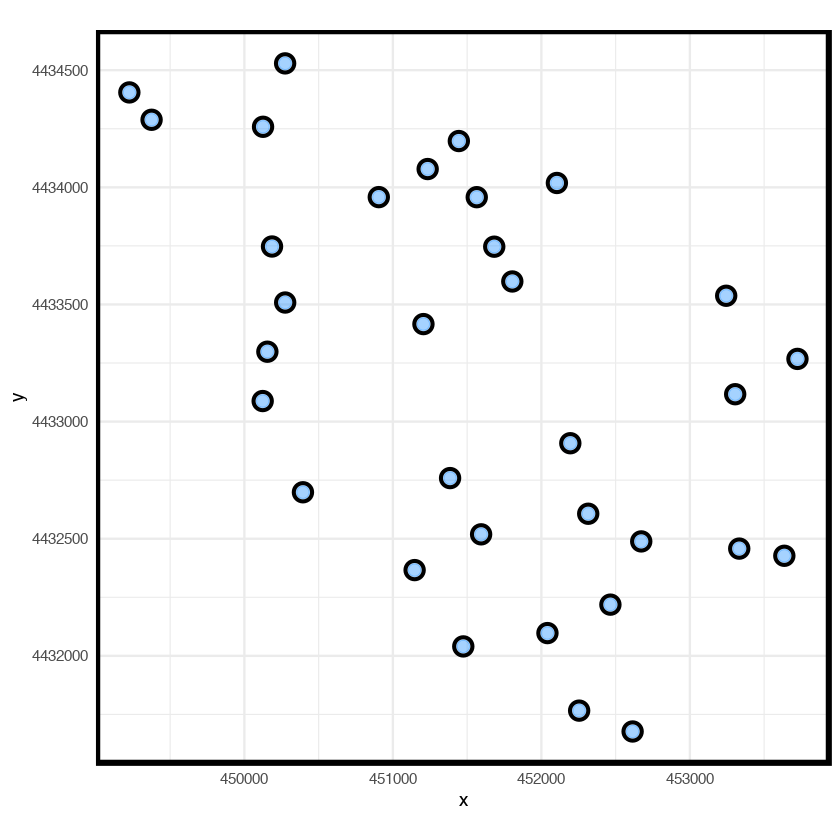

In [4]:
presence_absence_data %>% 
    group_by(plot) %>% 
    summarize(x=mean(Easting), y=mean(Northing)) %>% 
    ggplot(aes(x, y)) + 
        geom_point(size=3,alpha=0.4, color='dodgerblue') +
        geom_point(size=4,stroke=1.3,shape=1) + 
        theme_minimal() + 
        theme(aspect.ratio=1, panel.border=element_rect(fill=NA,size=2))

#### Environmental Variables

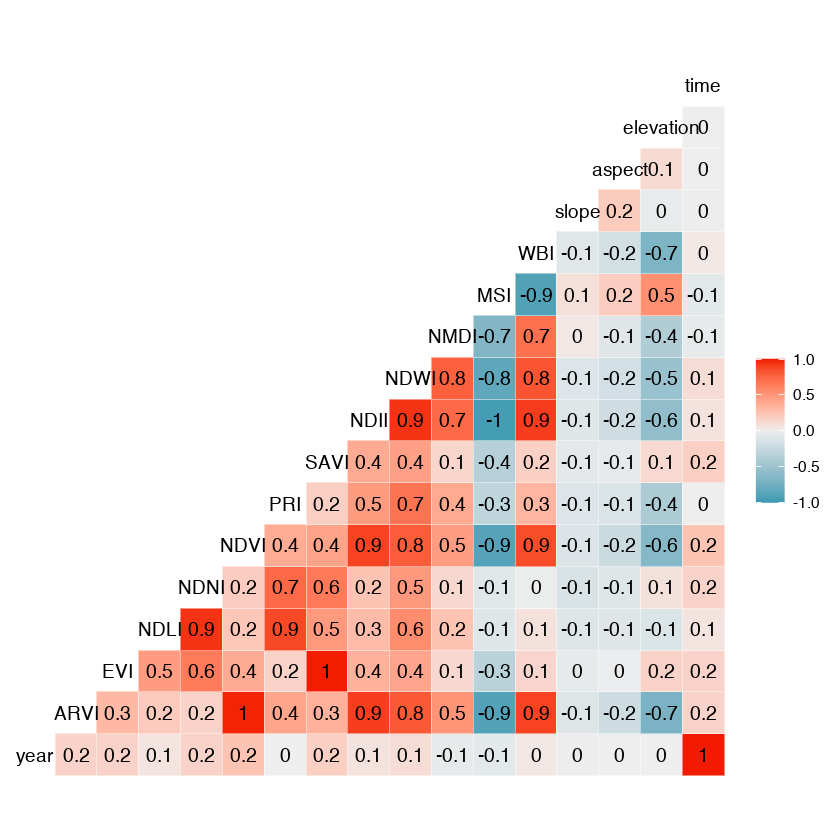

In [9]:
ggcorr(presence_absence_data[,11:ncol(presence_absence_data)-2], label=T)

Since these are all highly correlated and many are measuring the same thing or actually derived from one another, we used PCA to get three new synthetic variables to use as predictors (spoiler alert: they don't work much better than the raw indices). This was also to avoide having to do manual feature selection, since that would be a lot of variables to try combinations of. 


### Presence by plot over time

The plot below here shows how occupancy changed over three years at each site. Color indicates subplot.

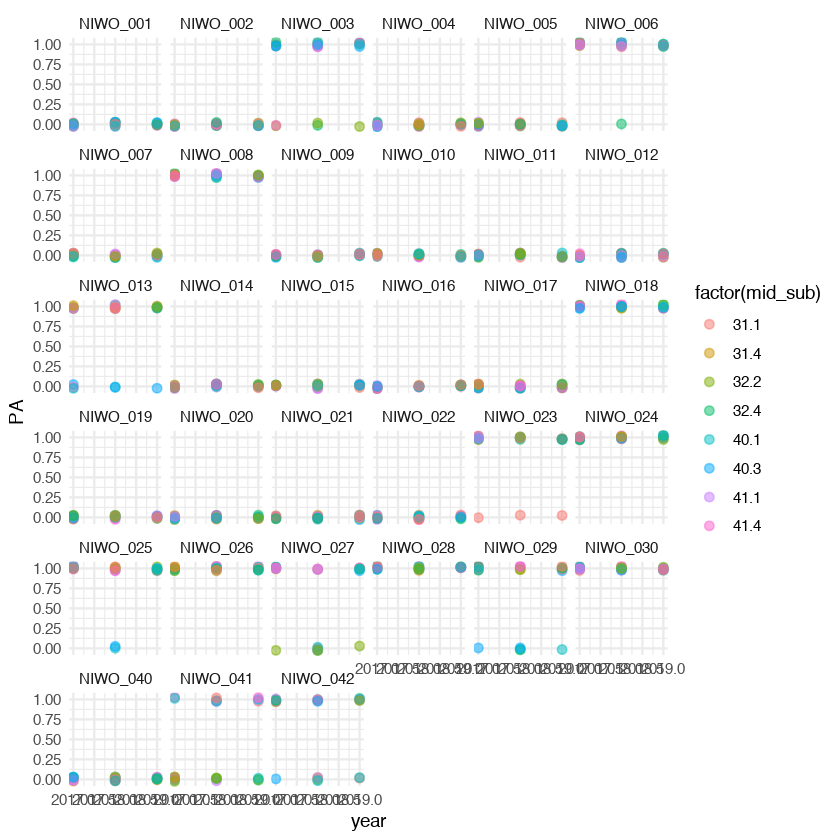

In [10]:
presence_absence_data %>%
    group_by(plot, year) %>%
    ggplot(aes(year, PA, color=factor(mid_sub))) + 
    geom_jitter(height=0.03,width=0, size=2, alpha=0.5) + 
    facet_wrap(. ~ plot) + 
    theme_minimal() 

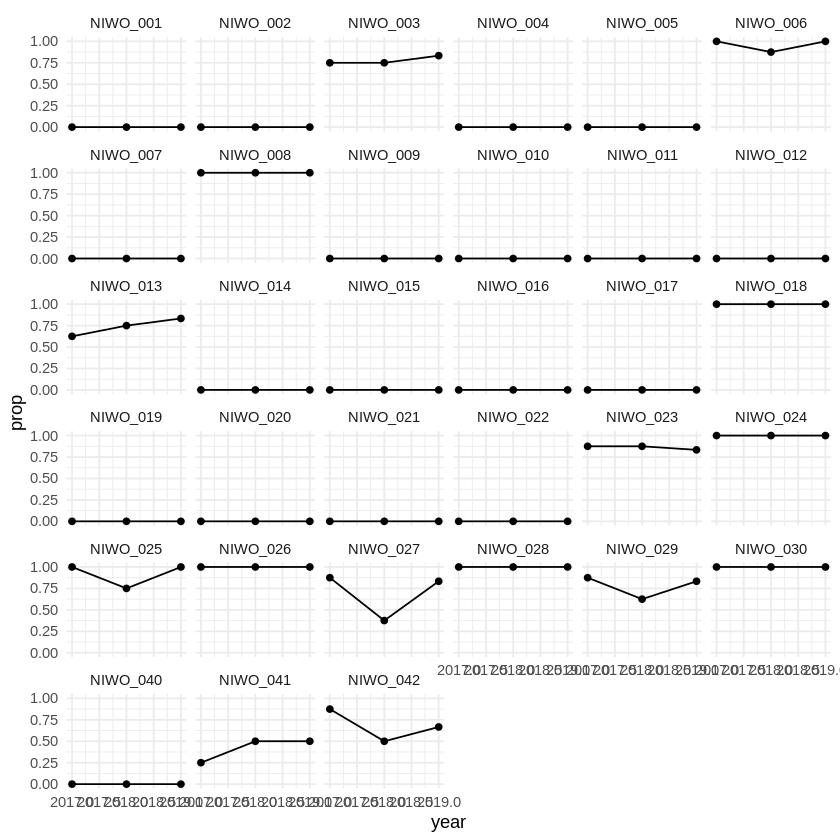

In [8]:
presence_absence_data %>% 
    group_by(plot, year) %>%
    summarize(prop=sum(PA)/length(PA)) %>%
    ggplot(aes(year, prop)) + geom_line() + geom_point() + facet_wrap(. ~ plot) + theme_minimal() + ylim(0,1)

## III. Models

### PCA Models

I've pulled a set of models in here rather than running them in the document itself here. This is mostly because it makes everything quite cluttered. So here they are. All models were fit with a binomial distribution using stan as implemented via the rethinking package by Richard McElreath. Plot was included as a "random effect" to allow for partial pooling. Priors for all fixed effects were set as dnorm(0,1.5). Hyperpriors for the random effect were: mean: dnorm(0,1.5) and var: dgamma(1,2). 

In [5]:
pca_models = readRDS("PC_models_all_year.RDS")

#total pooling
intercept_year_model = pca_models[[1]]

#partial pooling at plot level
plot_model = pca_models[[2]]

#partial pooling with exponential elevation relationship

elev_model = pca_models[[3]]

#just first principal component

pc1_model = pca_models[[4]]

#first two axes

pc2_model = pca_models[[5]]

#first three axes

pc3_model = pca_models[[6]]


#let's spoil the surprise some more and just compare these outright using the compare function from rethinking

all_year_comparison = rethinking::compare(intercept_year_model,plot_model, elev_model, pc1_model,pc2_model,pc3_model)
all_year_comparison


,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
elev_model,226.9285,21.25736,0.0000000,NA,11.008838,4.678391e-01
plot_model,227.2836,21.27172,0.3551266,0.1390009,11.032472,3.917254e-01
pc1_model,229.8089,21.41732,2.8804327,3.7070980,11.987209,1.108201e-01
pc2_model,232.6387,21.83142,5.7102004,5.3954719,12.935651,2.692417e-02
pc3_model,237.2447,22.91585,10.3162929,7.8339247,14.644577,2.691175e-03
intercept_year_model,954.0414,11.33865,727.1129750,24.1035588,1.944466,6.018942e-159


Here we see that our "best" model so far as WAIC and Akaike weight are concerned is the model with plot and elevation included. The only PCA model that made the cut included just the first principal component. So let's take a look at the coefficients for both of those.


33 vector or matrix parameters hidden. Use depth=2 to show them.



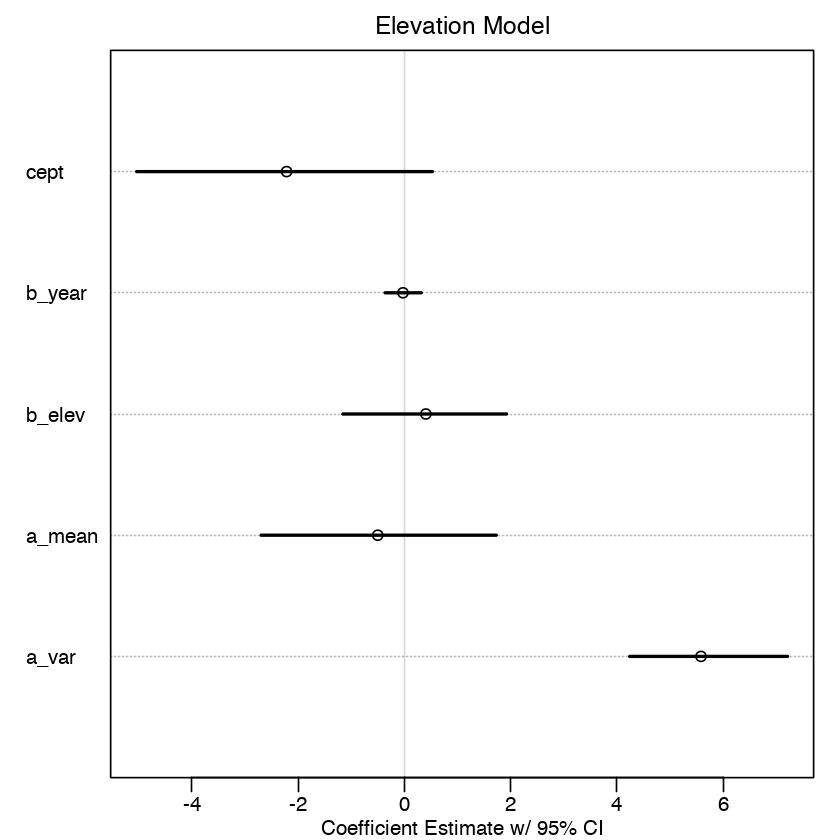

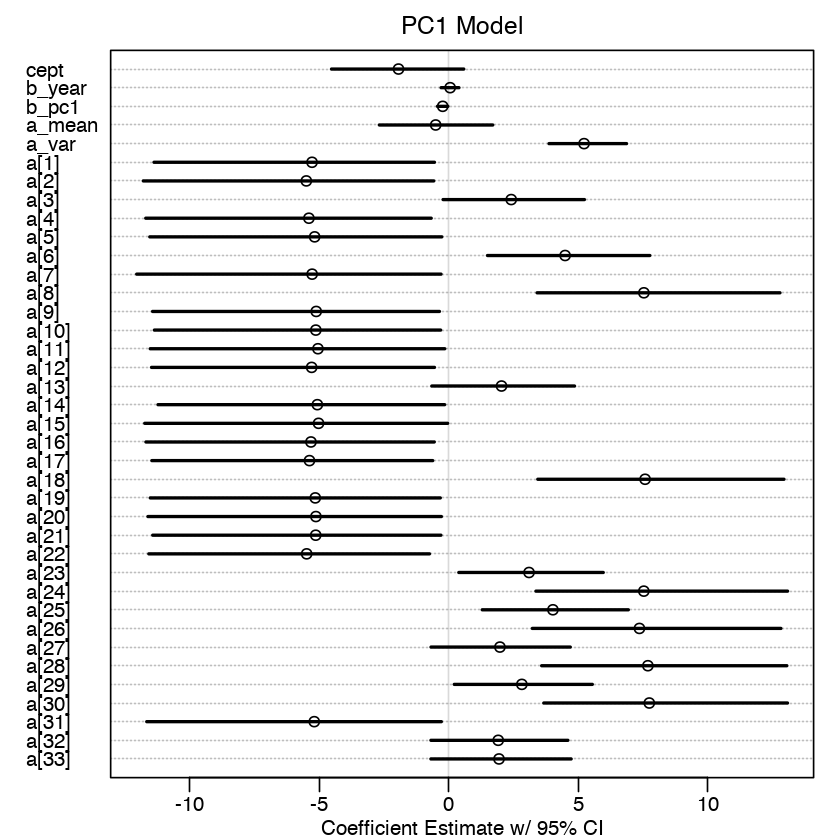

In [52]:
plot(precis(elev_model), main="Elevation Model", xlab="Coefficient Estimate w/ 95% CI")
plot(precis(pc1_model, depth=2), main ="PC1 Model", xlab="Coefficient Estimate w/ 95% CI")

Here we see that our elevation model, which included year, plot, and squared elevation, has no non-zero coefficients (aside from the variance for our random effect plot). The principal component model has a (barely) non-zero coefficeint for the first axis. However, this model ranked third in terms of WAIC and Akaike weight and so that effect may be spurious in this case.

### Models by Year

Given that year had no effect in any of our models, we thought it might be interesting to try and predict the next year from a model fit on the year before. So here are those models. Each of these objects has the same models as before, but now fit on a subset of our data. So 2017 models contains: intercept model, plot only model, plot and elevation model, pc1 model, pc1+pc2 model, and pc1+pc2+pc3 model. For now we'll just focus on 2017.

In [28]:
models_2017 = readRDS("2017_models_pca.RDS")
models_2018 = readRDS("2018.models.RDS")
models_2019 = readRDS("2019.models.RDS")

cept_mod17 = models_2017[[1]]
plot_mod17 = models_2017[[2]]
elev_mod17 = models_2017[[3]]
pc1_mod17 = models_2017[[4]]
pc2_mod17 = models_2017[[5]]
pc3_mod17 = models_2017[[6]]

compare_2017= rethinking::compare(cept_mod17, plot_mod17, elev_mod17, pc1_mod17, pc2_mod17, pc3_mod17)
compare_2017


,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
plot_mod17,78.05230,15.516127,0.0000000,NA,9.8502541,5.838530e-01
elev_mod17,78.73151,15.808805,0.6792092,0.3122066,10.3006516,4.157336e-01
pc1_mod17,92.57095,20.227646,14.5186480,13.8133532,14.5390158,4.107894e-04
pc2_mod17,102.73108,21.855691,24.6787758,15.2762904,16.5336840,2.554909e-06
pc3_mod17,112.72007,24.166032,34.6677647,18.1056071,18.3920344,1.730988e-08
cept_mod17,356.79133,6.617081,278.7390235,16.9981134,0.9665736,1.733379e-61


In [51]:
summary(plot_mod17)

Inference for Stan model: a9f7c1b2e06ec15305c364683864ee8c.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

          mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff Rhat
cept     -2.01    0.07 1.91   -5.86   -3.25   -1.99   -0.73    1.75   823    1
a_mean   -0.43    0.04 1.39   -3.15   -1.37   -0.44    0.50    2.28  1514    1
a_var     9.49    0.15 3.35    5.15    7.22    8.81   10.96   17.92   516    1
a[1]     -8.08    0.18 6.83  -25.28  -11.28   -6.65   -3.26    1.13  1496    1
a[2]     -8.26    0.20 7.38  -25.15  -11.46   -6.71   -3.34    0.96  1377    1
a[3]      3.25    0.07 2.10   -0.84    1.86    3.22    4.64    7.50   968    1
a[4]     -7.89    0.16 6.59  -24.54  -11.02   -6.45   -3.29    0.91  1768    1
a[5]     -8.05    0.19 7.27  -26.06  -11.04   -6.57   -3.26    0.80  1523    1
a[6]     10.68    0.22 6.83    2.40    6.36    9.19   13.42   27.03   990    1
a[7]     -8.31    0.19 7.19  -25

Once again, we find that our plot level model is best, with an elevation model having similar WAIC and Akaike weight. Since elevation at a given plot doesn't change year on year, we'll go with the plot only model to try and predict on to 2018. Let's all just take a moment to hope this works.

In [33]:

geum_2018 = presence_absence_data %>% filter(year==2018)

preds_2018=rethinking::sim(fit = plot_mod17, data=geum_2018, n=100)
geum_2018$preds_avg = apply(preds_2018, 2, mean)

[ 100 / 100 ]


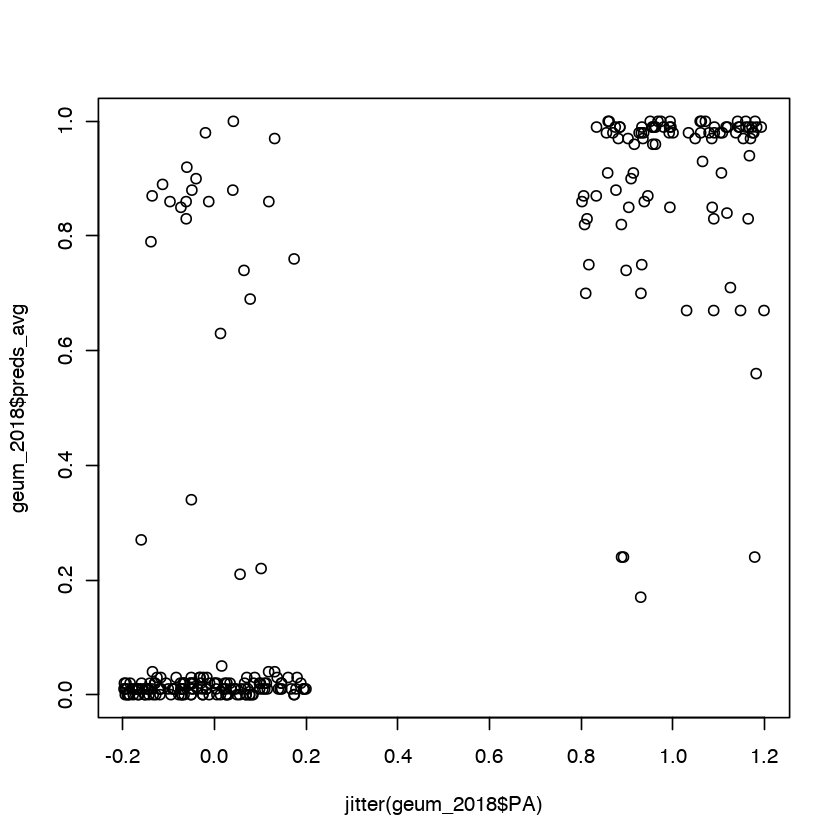

In [34]:
plot(x=jitter(geum_2018$PA), y=geum_2018$preds_avg)

Here we have our 2018 observations along the x axis and our predicted values on the y. In this case, the predictions are averages from 100 draws from the posterior. I've jittered the x axis so it's easier to see, but basically we've made some okay predictions. We can get into a bit more detail about those predictions with the next chunk of code here. On the off chance you're running this yourself, feel free to play with the threshold for positive/negative prediction in the function below which I arbitrarily set at 0.6. I think lots of SDM papers use 0.75, but hey live a little why don't you? let loose.

In [35]:
confusion_calc = function(data){
    false_negative=length(which(data$PA==1&data$preds_avg<0.6))
    false_positive=length(which(data$PA==0&data$preds_avg>0.6))
    total_wrong = false_negative+false_positive
    fn_freq=false_negative/total_wrong
    fp_freq=false_positive/total_wrong
    all_pos=length(which(data$preds_avg>0.6))
    prop_false_pos=false_positive/all_pos
    
    return(data.frame(total_wrong=total_wrong,false_negative=false_negative,false_positive=false_positive,fn_freq=fn_freq,
                      fp_freq=fp_freq,prop_false_pos=prop_false_pos))
}

confusion_results=confusion_calc(geum_2018)
confusion_results


total_wrong,false_negative,false_positive,fn_freq,fp_freq,prop_false_pos
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
25,5,20,0.2,0.8,0.1801802


So we have 25 total incorrect predictions, 5 of which are false negatives, 20 of which are false positives (not great). Of the positive predictions we made, 18% were incorrect, so we're wrong about _Geum_ presence almost 1 out of every 5 times. Ah well c'est la vie, non?

In [49]:
cept_mod18 = models_2018[[1]]
plot_mod18 = models_2018[[2]]
elev_mod18 = models_2018[[3]]
pc1_mod18 = models_2018[[4]]
pc2_mod18 = models_2018[[5]]
pc3_mod18 = models_2018[[6]]

compar_18 = rethinking::compare(cept_mod18,plot_mod18,elev_mod18,pc1_mod18,pc2_mod18,pc3_mod18)
compar_18



,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
elev_mod18,116.7423,13.80683,0.0000000,NA,11.178943,5.095724e-01
plot_mod18,116.9566,13.73627,0.2142508,0.2056046,11.034427,4.578065e-01
pc1_mod18,122.5617,14.80309,5.8193872,5.2536659,12.673090,2.776784e-02
pc3_mod18,126.0738,19.36902,9.3314922,12.5551905,15.765470,4.796209e-03
pc2_mod18,134.9380,19.04537,18.1956859,13.0845699,14.792923,5.702469e-05
cept_mod18,348.0999,8.81413,231.3575774,15.7979245,1.002767,2.941347e-51


In [50]:
geum_2019=presence_absence_data%>%filter(year==2019)
preds_2019=rethinking::sim(plot_mod18,geum_2019,n=100)
geum_2019$preds_avg=apply(preds_2019,2,mean)

confusion_19=confusion_calc(geum_2019)
confusion_19

[ 100 / 100 ]


total_wrong,false_negative,false_positive,fn_freq,fp_freq,prop_false_pos
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
17,13,4,0.7647059,0.2352941,0.05633803


Now we have 17 wrong, with more false negatives than positives. So our model predictions may not even consistently trend towards over or under prediction of _Geum_ presence. Not ideal, I gotta say.

### Maximum Entropy Models

Since projecting forward in time is a bit dubious, given that we're just predicting that _Geum_ will be where it was last year, we decided to play around with predicting across space. Since none of our abiotic variables did a great job of prediction, it led to some not great predictions over our rasters using the hierarchical models. Below is a predicted raster for 2017 using our best fit model, which included only plot and elevation. Since elevation had a zero coefficient and plot doesn't generalize beyond our study sites, we get some lovely static.

<img src = "Rplot01.jpeg">

So we jumped on the maximum entropy bandwagon and tried the maxnet R package, which is implemented with rJava and dismo. It may not work on your computer so I apologize in advance if that's the case.

In [38]:
max_ent_models=readRDS("max_ent_models_all_years.RDS")
max_ent_maps=readRDS("max_ent_maps_all_years.RDS")

ME_2017=max_ent_models[[1]]
ME_2018=max_ent_models[[2]]
ME_2019=max_ent_models[[3]]
map_2017=max_ent_maps[[1]]
map_2018=max_ent_maps[[2]]
map_2019=max_ent_maps[[3]]



Maximum Entropy is...weird. Which is to say, the model that you end up fitting is pretty opaque compared to a nice and neat hierarchical model like above. The code was proprietary and only accessible through a Java GUI for a long time, but now its open source and integrated (somewhat) into R. The core idea is to try an optimize some probability distribution for species presence at sites by minimizing the relative entropy between the abiotic factors at sites where we know the species exists and the distribution of those factors across the entire landscape. Getting that probability distribution is tricky though, and MaxEnt makes a lot of behind-the-scenes decisions for you that can be tough to track down or understand. 

It's two key advantages (we would argue) have little to do with minimizing relative entropy. Instead, they are related to how the model itself is fit. First off, it regularizes coefficients similar to lasso regression (L1 regularization). This allows some coefficients to shrink to 0, while keeping the rest small as well. This acts as a form of feature selection, and opinions seem to be divided on whether or not it is best to process correlated predictors (like we did for our hierarchical models) before throwing them into MaxEnt. We chose not to.

The second advantage is that, depending on how much data you pass it, MaxEnt automatically tests a variety of functional shapes for the relationship between species presence and abiotic covariates. By default (if there is sufficient data), it will test linear, product, quadratic, threshold, and hinge functions. Threshold functions are like piece-wise functions and hinge functions are similar to basis functions in GAMs (apparently). Product terms allow for interactions as well as exponential relationships. The upside to all of this is that you get to test all kinds of combinations of your predictors and see how they best predict your species' distribution. The downside is that its damn near impossible to reconstruct an explicit model to describe these relationships. Case and point, the chunk below will show you the "lambdas" (basically model coefficients) for our 2017 model. (Oh, another downside, I couldn't figure out time series data so we had to fit separate models and accounting for spatial bias in sampling is pretty tricky, so we didn't)

In [45]:
ME_2017@lambdas

[1] "ARVI.2017, 0.0, -0.256461262702942, 1.66666674613953" 
[2] "DII.2017, 0.0, -0.449285835027695, 0.856980681419373" 
[3] "DWI.2017, 0.0, -0.350054532289505, 0.443511098623276" 
[4] "EVI.2017, 0.0, -0.0267765298485756, 0.800321817398071"
[5] "MDI.2017, 0.0, 0.0, 1.14720797538757"                 
[6] "MSI.2017, 0.0, 0.0, 2.55022978782654"

Okay, let's just look at that first line for ARVI (below). From what I can tell, these are effectively confidence intervals for coefficients. So ARVI has a 0 coeff with CI's that extend above and below. This seems to be true for most of these parameters, in that they have three values, a mid followed by a lower and upper bound. The issue is, some also have more complex notation, see the various lines with lots of parentheses. Once again, full disclosure, no idea what those are. Presumably these are conditions for the various threshold and hinge terms, like the second line of output below. So when EVI is greater than 0.194, the coefficient for EVI is estimated at 0.14 with a lower bound of 0 and an upper bound of 1. Maybe. 

In [47]:
head(ME_2017@lambdas,1)
ME_2017@lambdas[35]

[1] "ARVI.2017, 0.0, -0.256461262702942, 1.66666674613953"

[1] "(0.1964435651898384<EVI.2017), 0.14194667477826634, 0.0, 1.0"

Since interpreting this output is a bit tricky, let's skip that and look at partial response curves for 2017 instead.

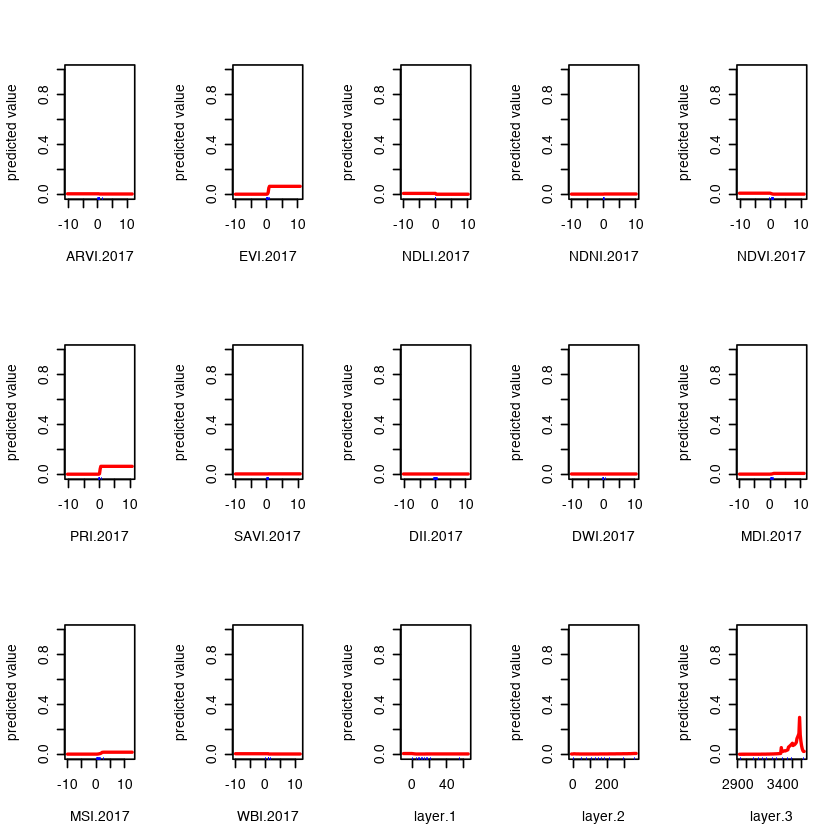

In [40]:
response(ME_2017)

These show how our prediction changes as a function of each variable across its feasible range. Here we see no effect for most of our indices (gotta love regularized regression amirite?), with sharp predictive power on EVI, PRI, and elevation (here called layer 3).

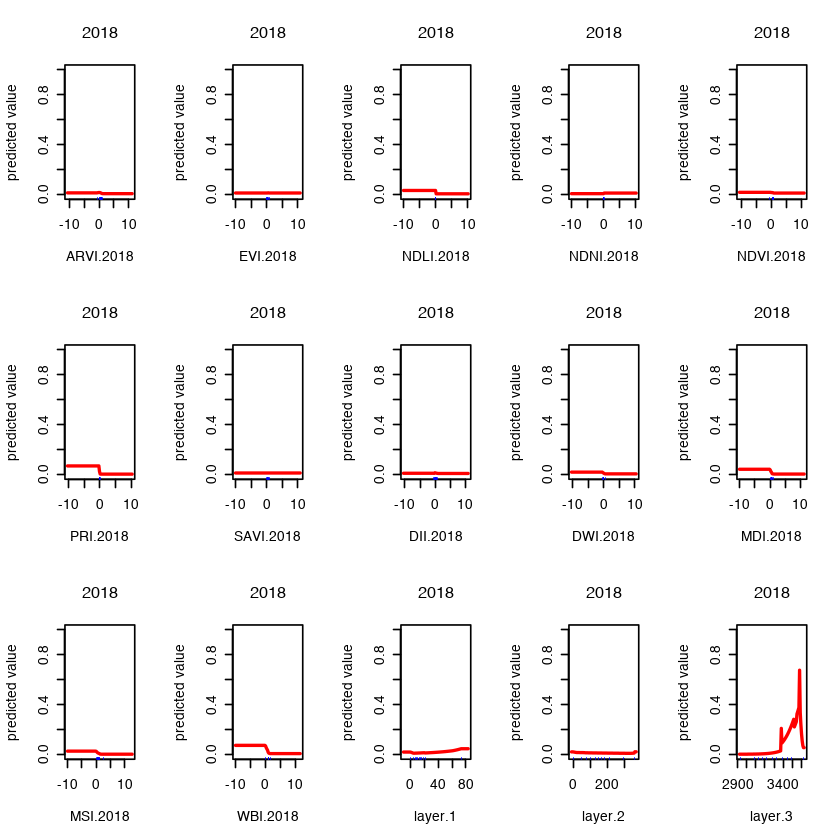

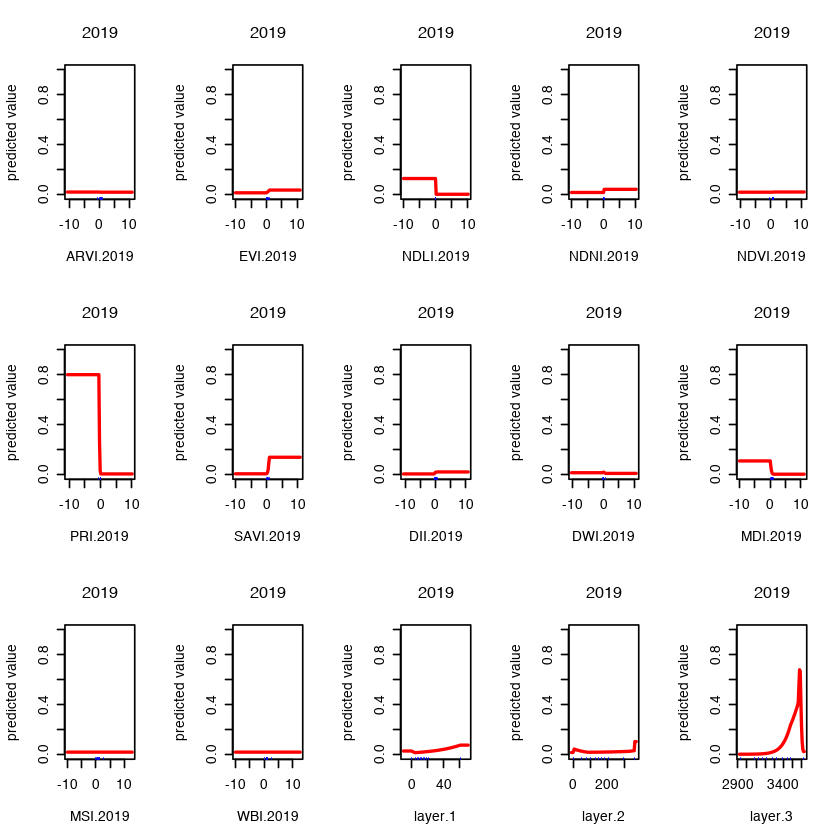

In [43]:
response(ME_2018, main="2018")
response(ME_2019, main="2019")

So across these three sets of plots, we can see there are few consistent predictors of _Geum_ distribution aside from elevation. Given that _Geum rossii_ only grows in high altitude or high latitude environments, that's not too wild. But we do see PRI picking up some stronger signal over the years, but it actually reverses, so that in 2017, higher PRI meant higher probability of _Geum_ while in 2018 and 2019 the opposite is true. That's not great. Worth noting that PRI is the Photochemical Reflectance Index - an index of xanthophyll cycle activity during the day.

Before we wrap on MaxEnt, let's look at all those maps.

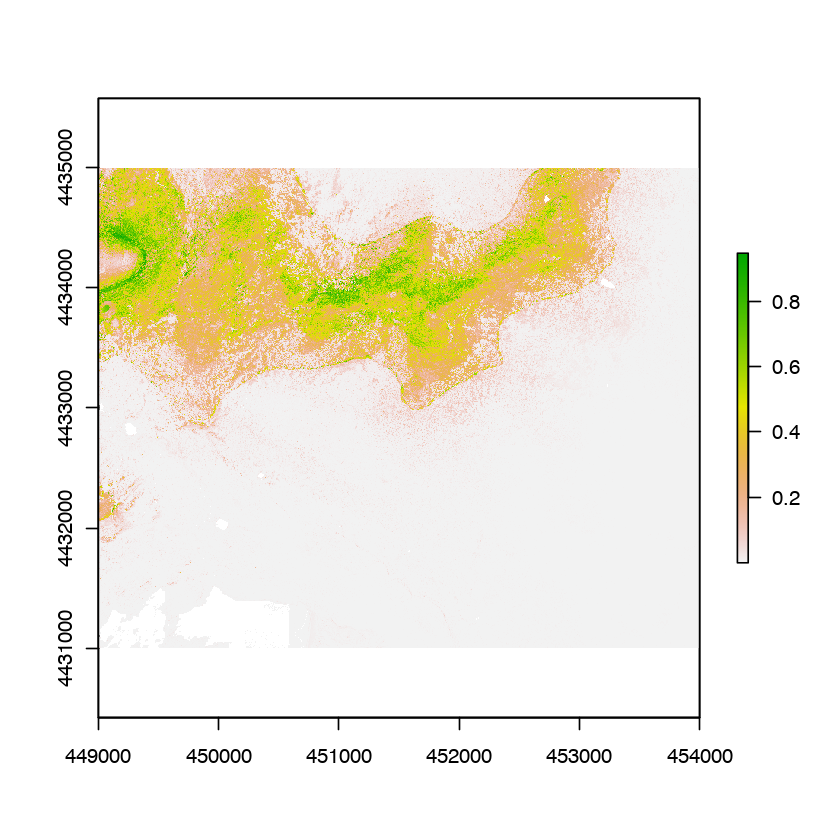

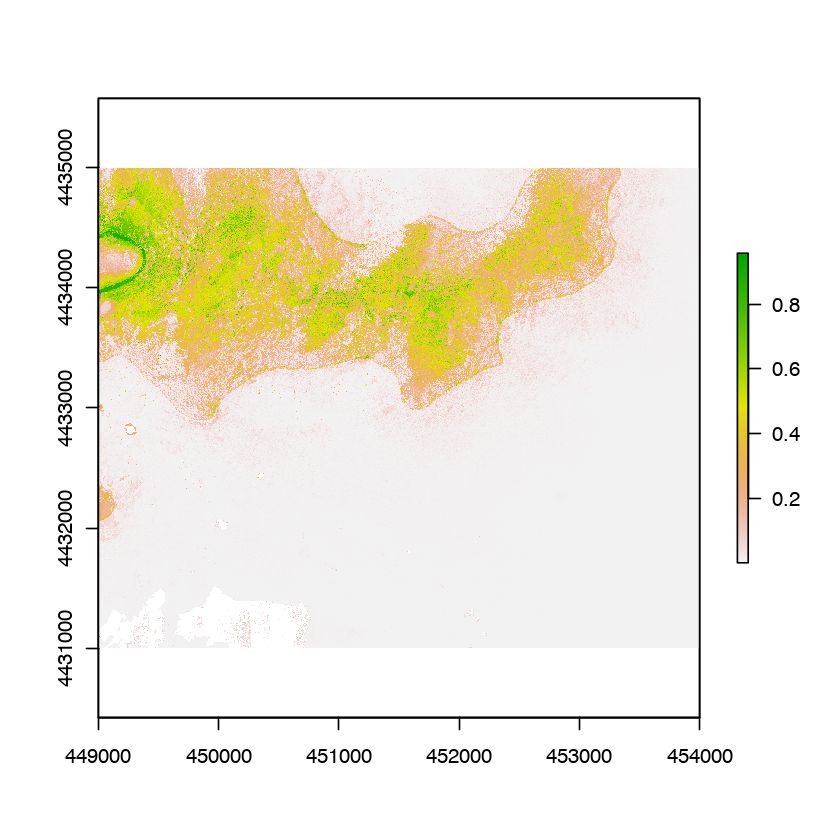

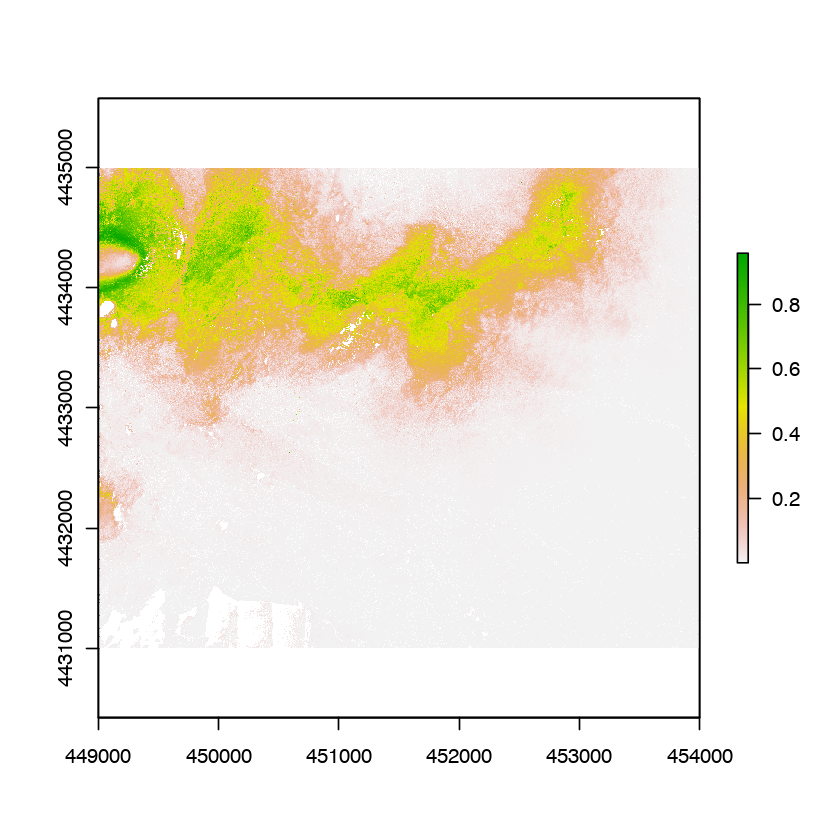

In [44]:
plot(map_2017)
plot(map_2018)
plot(map_2019)

Also a nice ROC curve, if you like that sort of output. Based on this, we're predicting better than random with our MaxEnt model, since the red line is well above the black there.

<img src="ROC.curve.Geum.maxent.png">

# Conclusions

So what can we say in the end? Can we predict whether or not _Geum_ will persist at sites where it has been seen in the past? Not really, we'll potentially be wrong a fair amount of the time based on our Bayesian models. Can we predict where it will exist across space? Arguably no moreso than if we quickly googled _Geum rossii_, saw that it grows at high altitudes, and guessed that it'll probably grow at higher altitude sites. I'm not saying I did that I'm just saying it'd probably have similar predictive power. Don't quote me on that though.

What we can say, is that for the purposes of predicting the distribution of this single alpine plant species, lidar derived vegetative, moisture, and nitrogen indices aren't great options. Covariance among the indices makes parsing signal difficult, and few of them seem strongly predictive using strictly linear terms. Dealing with transformations and interactions opens up a lot of opportunities (as demonstrated by MaxEnt) but also creates issues of interpretation and statistical power - depending on how complex those nonlinear responses need to be.



### 3.1 Total Pooling, No Effects

- Total pooling, intercept only, no predictors
- effectively the same as logistic regression of PA with no predictors

$$S_i \sim Bernoulli(p_i) \quad\quad \text{likelihood}$$

$$\text{logit}(p_i) = \alpha \quad\quad \text{link}$$

$$\alpha \sim \text{N}(0,0.5)$$

In [8]:
model3.1 = map2stan(
    alist(
        PA ~ dbinom(1, p),
        logit(p) <- a,
        a ~ dnorm( 0, 5 )
    ),
    data=na.omit(presence_absence_data))
model3.1
model3.1_posterior = data.frame(extract.samples(model3.1))


SAMPLING FOR MODEL '92b441b9af666595bc63df91a6300a67' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 9.1e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.91 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.415119 seconds (Warm-up)
Chain 1:                0.327284 seconds (Sampling)


Computing WAIC



map2stan model
1000 samples from 1 chain

Sampling durations (seconds):
        warmup sample total
chain:1   0.42   0.33  0.74

Formula:
PA ~ dbinom(1, p)
logit(p) <- a
a ~ dnorm(0, 5)

WAIC (SE): 952 (11.2)
pWAIC: 0.91 

#### 3.1.1 Model Visualization

In [6]:
model3.1_posterior$p = exp(model3.1_posterior$a) / (exp(model3.1_posterior$a) + 1)
model3.1_posterior$sigma = n_plots * model3.1_posterior$p * (1-model3.1_posterior$p) 

In [10]:
distribution_posterior = data.frame(matrix(ncol=3))
colnames(distribution_posterior) = c("x", "pr_x", "sample")
interval = rep(seq(0,33,by=0.1), n_plots)
r = 1

n_samples = length(model3.1_posterior$a)
for (r in 1:5){
    p_hat = rep(model3.1_posterior[r,]$p, length(interval))
    sigma_hat = rep(model3.1_posterior[r,]$sigma, length(interval))
    pr_x = exp((-1*(interval-p_hat)^2)/sigma_hat^2)  
    
    this_df = data.frame(x=interval, pr_x=pr_x, sample=rep(r, length(interval)))
    
    distribution_posterior = rbind(distribution_posterior, this_df)
}
#pr_x = exp((-1*(interval-model3.1_posterior$p)^2)/model3.1_posterior$sigma^2)

x,pr_x,sample
<dbl>,<dbl>,<int>
NA,NA,NA
0.0,0.9975059,1
0.1,0.9986115,1
0.2,0.9993960,1
0.3,0.9998588,1
0.4,0.9999993,1
0.5,0.9998175,1
0.6,0.9993135,1
0.7,0.9984879,1


### 3.2 Total Pooling, Indepedent Effects

The dang ol' linear model. 

$$S_i \sim Bernoulli(p_i)  \quad\quad\quad\quad \text{likelihood}$$ 

$$p_i = \text{logit}(\alpha_i + \sum_j \beta_j x_{ij}) \quad\quad\quad\quad \text{link} $$

$$\alpha \sim N(0, 5) \quad\quad\quad\quad\text{intercept prior}$$ 

In [61]:
model3.2 = ulam(
    # model definition
    alist(
        PA ~ dbinom(1, p),
        logit(p) <- a 
                    + beta_time*time 
                    + beta_NDNI*NDNI 
                    + beta_NDLI*NDLI 
                    + beta_NDWI*NDWI
                    + beta_EVI*EVI
                    + beta_ARVI*ARVI
                    + beta_aspect*aspect
                    + beta_slope*slope,
        beta_time ~ dnorm(0,5),
        beta_NDNI ~ dnorm(0,5),
        beta_NDLI ~ dnorm(0,5),
        beta_NDWI ~ dnorm(0,5),
        beta_EVI ~ dnorm(0,5),
        beta_ARVI ~ dnorm(0,5),
        beta_aspect ~ dnorm(0,5),
        beta_slope ~ dnorm(0,5),
        a ~ dnorm( 0, 5 )
    ),
    data=na.omit(presence_absence_data))
post = extract.samples(model3.2)

Removing one or more character or factor variables:

plot




SAMPLING FOR MODEL '324f47f325978f1571c7752fdf36c125' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000343 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 3.43 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:   1 / 1000 [  0%]  (Warmup)
Chain 1: Iteration: 100 / 1000 [ 10%]  (Warmup)
Chain 1: Iteration: 200 / 1000 [ 20%]  (Warmup)
Chain 1: Iteration: 300 / 1000 [ 30%]  (Warmup)
Chain 1: Iteration: 400 / 1000 [ 40%]  (Warmup)
Chain 1: Iteration: 500 / 1000 [ 50%]  (Warmup)
Chain 1: Iteration: 501 / 1000 [ 50%]  (Sampling)
Chain 1: Iteration: 600 / 1000 [ 60%]  (Sampling)
Chain 1: Iteration: 700 / 1000 [ 70%]  (Sampling)
Chain 1: Iteration: 800 / 1000 [ 80%]  (Sampling)
Chain 1: Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain 1: Iteration: 1000 / 1000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 3.48878 seconds (Warm-up)
Chain 1:                2.85465 seconds (Sampling)
Chain 1:    

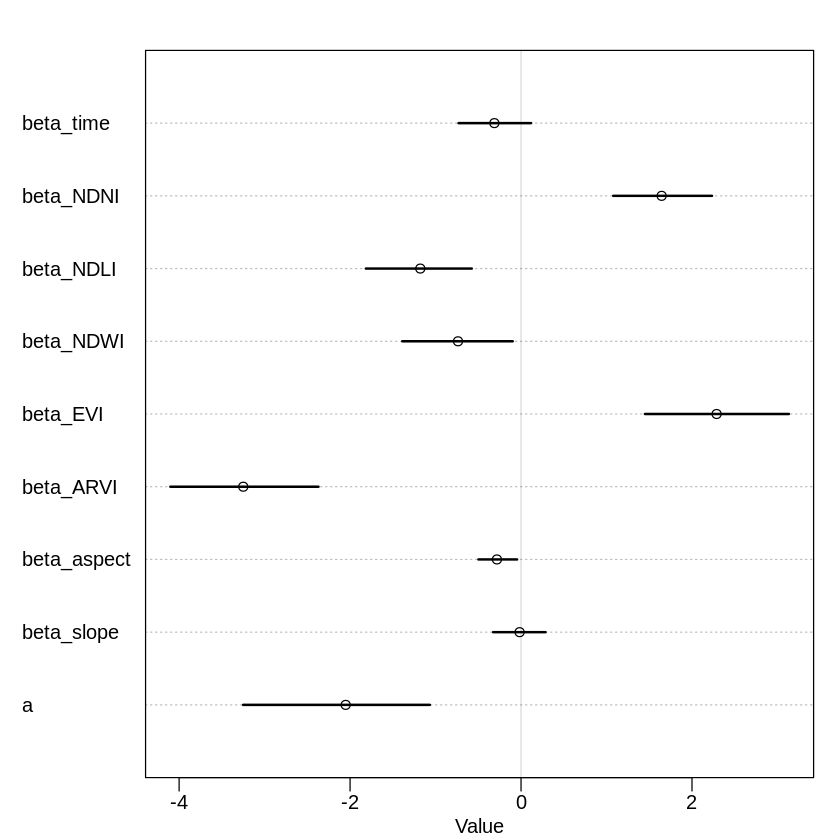

In [64]:
plot(precis(model3.2,depth=2)) # also plot

#### Varying Intercepts

$$S_i \sim Bernoulli(p_i)  \quad\quad\quad\quad\quad\quad \text{likelihood}$$ 

$$p_i = \text{logit}(\alpha_i + \sum_j \beta_j x_{ij}) \quad\quad\quad\quad\quad\quad \text{link} $$

$$\alpha_i \sim N(\mu_\alpha, \sigma_\alpha) \quad\quad\quad\quad\quad\quad \text{intercept prior}$$ 

$$\mu_\alpha \sim  N(0, 5)  \quad\quad\quad\quad  \text{hyperprior for mean intercept} $$

$$\sigma^2_\alpha \sim  \text{Exp}(1)  \quad\quad  \text{hyperprior for intercept variance} $$

In [4]:
varying_intercepts = map2stan(
    # model definition
    alist(
        PA ~ dbinom(1, p),
        logit(p) <- a 
                    + beta_time*year 
                    + beta_NDNI*NDNI 
                    + beta_NDLI*NDLI 
                    + beta_NDWI*NDWI
                    + beta_EVI*EVI
                    + beta_ARVI*ARVI,
        beta_time ~ dnorm(0,5),
        beta_NDNI ~ dnorm(0,5),
        beta_NDLI ~ dnorm(0,5),
        beta_NDWI ~ dnorm(0,5),
        beta_EVI ~ dnorm(0,5),
        beta_ARVI ~ dnorm(0,5),
        a_mean ~ dnorm(0,1),
        a_var ~ dexp(1),
        a[plot] ~ dnorm( a_mean, a_var )
    ),
    data=na.omit(presence_absence_data))
post = extract.samples(varying_intercepts)

Warning message in coerce_index(d[[xvp$group]]):
“NAs introduced by coercion”



SAMPLING FOR MODEL 'f3d8f002800c25b9ca76c6d4bd2a1e8e' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.00046 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 4.6 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 93.7952 seconds (Warm-up)
Chain 1:                36.9954 seconds (Sampling)
Cha

Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Computing WAIC



Here is the 95% interval for the posterior of each parameter 

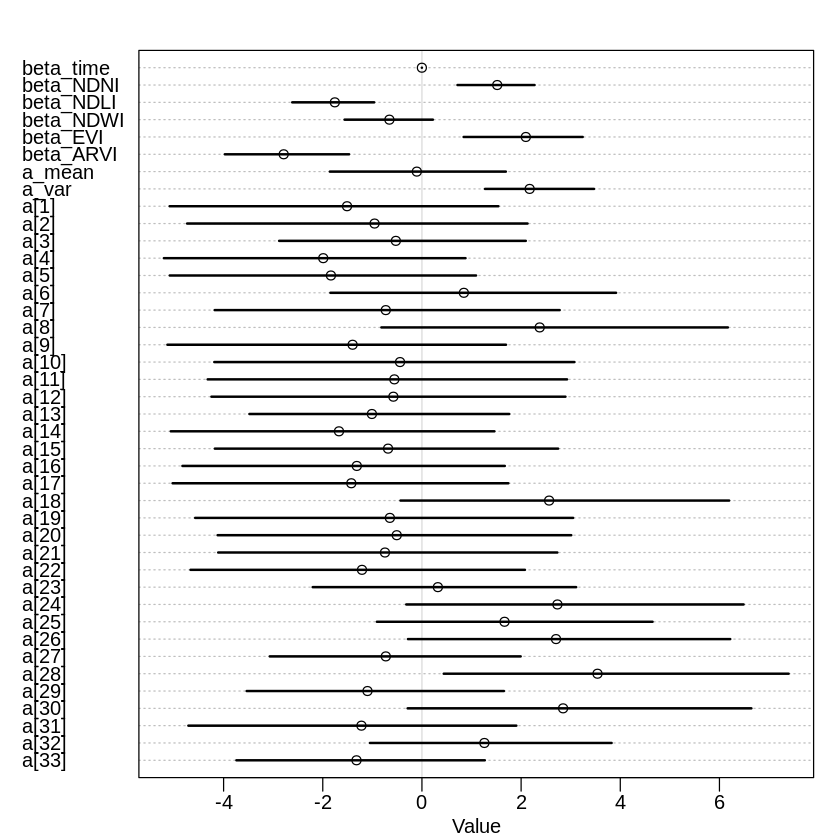

In [5]:
plot(precis(varying_intercepts,width=0.95,depth=2)) # also plot

### lets try this _without_ standardizing environmental indecies

In [25]:
no_stdization_presence_absence_data = read.csv('data.csv')
varying_intercepts_without_standardization = run_best_model(no_stdization_presence_absence_data)

Warning message in coerce_index(d[[xvp$group]]):
“NAs introduced by coercion”



SAMPLING FOR MODEL '9c61d79aeb06d5d7da8b49979f5e7cb3' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000387 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 3.87 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 10.282 seconds (Warm-up)
Chain 1:                6.62673 seconds (Sampling)
Ch

Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Computing WAIC



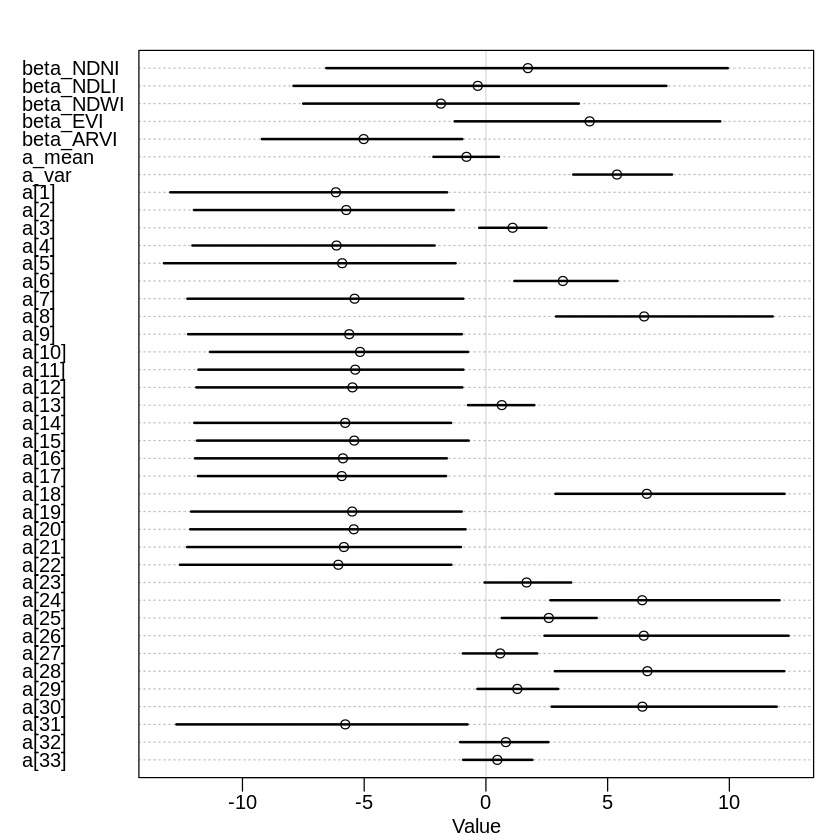

In [15]:
plot(precis(varying_intercepts_without_standardization,width=0.95,depth=2)) # also plot

In [26]:
## Plot occurance probs now/ with this model

## III. "forecasting"

- not a lot of temporal variance

In [22]:
geum_17 = presence_absence_data %>% filter(year==2017)
geum_17_and_18 = presence_absence_data %>% filter(year==2017, year == 2018)
geum_18 = presence_absence_data %>% filter(year==2018)
geum_19 = presence_absence_data %>% filter(year==2019)


### train on 2017 only, and predict 2018.

In [20]:
model_2017 = run_best_model(geum_17)

Warning message in coerce_index(d[[xvp$group]]):
“NAs introduced by coercion”



SAMPLING FOR MODEL 'd26cf0b96c3b480db1621aadf700706a' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000171 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.71 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 3.65786 seconds (Warm-up)
Chain 1:                2.49975 seconds (Sampling)
C

Warning message:
“There were 2 divergent transitions after warmup. Increasing adapt_delta above 0.95 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”
Warning message:
“There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”
Computing WAIC

Warning message in map2stan(alist(PA ~ dbinom(1, p), logit(p) <- a + beta_NDNI * :
“There were 2 diverg

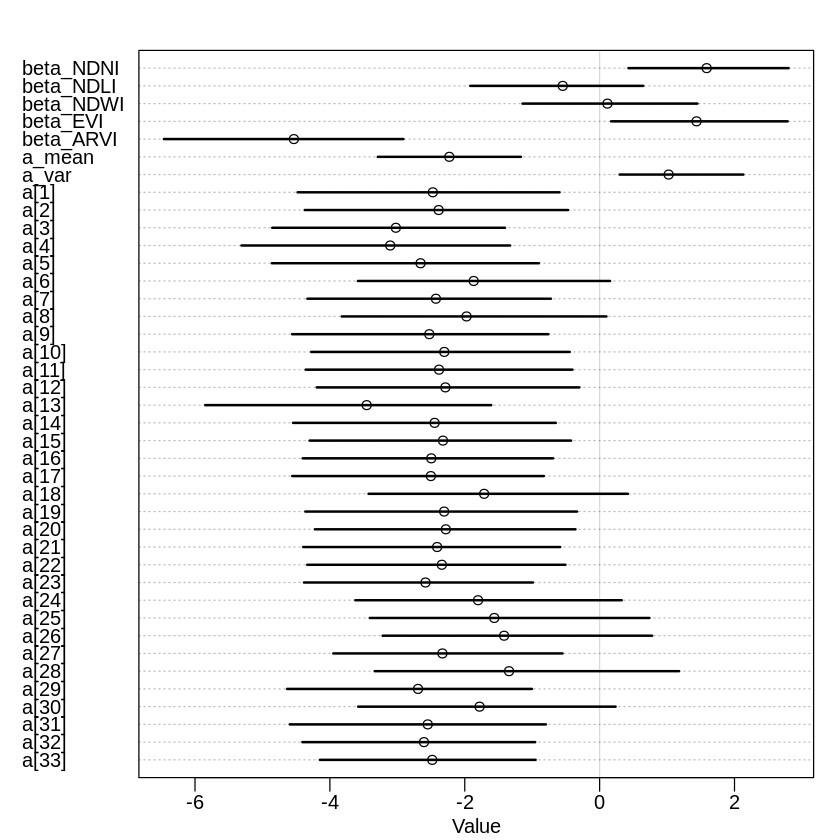

In [27]:
plot(precis(model_2017,width=0.95,depth=2)) # also plot

### how well does this model predict occupancy in 2018 and 2019?

### train on 2017 and 2018, predict 2019
- does more temporal data help?
- power analysis on how many timesteps do you need to detect temporal variability?

In [28]:
model_17_and_18 = run_best_model(geum_17_and_18)

Warning message in coerce_index(d[[xvp$group]]):
“NAs introduced by coercion”



SAMPLING FOR MODEL '0f9eac757f7efe3c9386e2b5aa7d4f7c' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000374 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 3.74 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 9.60538 seconds (Warm-up)
Chain 1:                7.20931 seconds (Sampling)
C

Computing WAIC



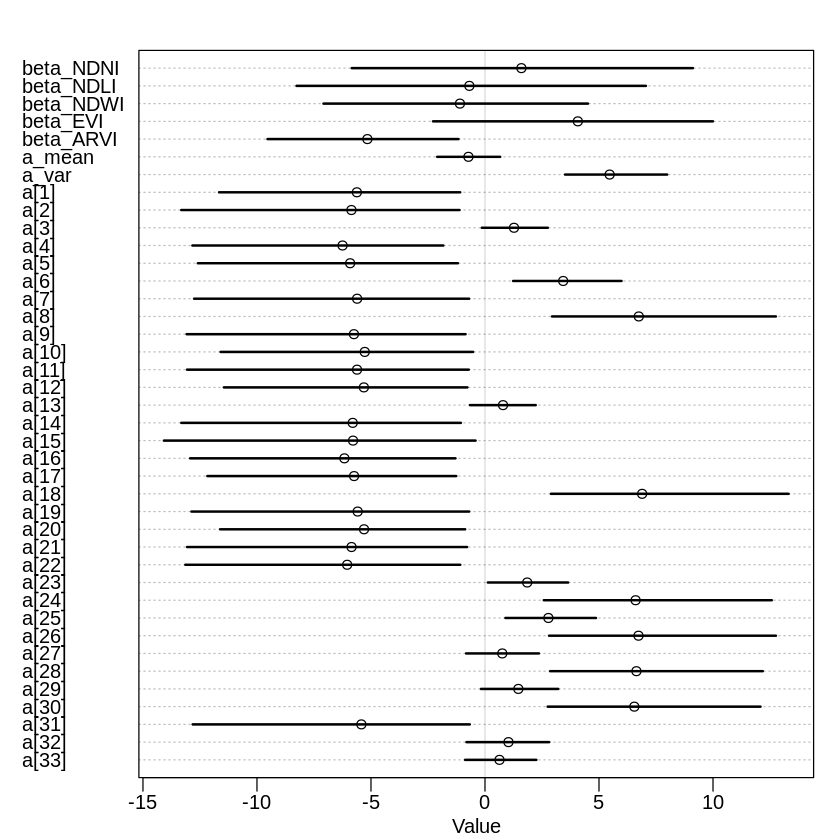

In [29]:
plot(precis(model_17_and_18,width=0.95,depth=2)) # also plot

## IV. future work
- causation vs. correlation of remote sensing indecies 
- how much temporal data would we need to forecast?
- propograting uncertainty from model fit to SDM
    - most GLM-based SDMs don't do this 